# 1. 사용자의 아이템 평점 데이터만을 활용해서 딥러닝 모델링


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten

# 딥러닝 layer 관련
from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

/Users/aiden/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

# 평점 데이터 "u.data" 가져오기
ratings = pd.read_csv('./u.data', 
                     names=r_cols,
                      sep='\t',
                      encoding='latin-1'
                     )
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# 학습,테스트 구분하기
ratings_train, ratings_test = train_test_split(ratings,
                                              test_size=0.2,
                                              shuffle=True,
                                              random_state=2022)

In [4]:
# RMSE 함수 (keras에는 RMSE 메소드 없어서 만들어줘야 함)
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [5]:
# 잠재 요인의 수 
K=200

# 전체 평점 평균
mu = ratings_train.rating.mean()

# 사용자id, 영화id의 최대값을 구한다.
# bias term의 크기 1을 고려하여 +1을 해준다.
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

In [6]:
print('사용자 개수 max값:', M)
print('아이템 개수 max값:', N)

사용자 개수 max값: 944
아이템 개수 max값: 1683


# 케라스 모델 생성

In [7]:
user = Input(shape=(1, ))
item = Input(shape=(1, ))

# 행렬 P,Q 임베딩
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

# 사용자, 아이템 평가 경향도 임베딩
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [8]:
# concatenate를 위해서는 1차원으로 Flatten해야 한다.
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)

user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

In [9]:
# layer 쌓기

# 노드가 2048개인 layer 생성.
# 활성화 함수는 'linear'
R = Dense(2048)(R)
R = Activation('linear')(R)

# 노드가 256개인 layer 추가
R = Dense(256)(R)
R = Activation('linear')(R)

# 노드가 1개인 dense layer(출력층) 한 개 추가
R = Dense(1)(R)

In [10]:
model = Model(inputs=[user, item], outputs=R)

model.compile(
    loss = RMSE,
    optimizer = SGD(),  # adam, adamax
    metrics= [RMSE]
)

model.summary()
# 사용자 수가 944, 잠재요인 수가 200 -> 944x200 = 188800
# concatenate를 위해 flatten

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [11]:
# 학습 데이터 정의
train_user_ids = ratings_train.user_id.values, 
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values

# 테스트 데이터 정의
test_user_ids = ratings_test.user_id.values, 
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values

In [12]:
%%time
# 학습시간 약 5분
result = model.fit(
    x = [train_user_ids, train_movie_ids], 
    y = train_ratings - mu,
    epochs = 65,
    batch_size = 512,
    validation_data = (
        [test_user_ids, test_movie_ids], 
        test_ratings - mu
    )
)

Epoch 1/65
157/157 [==============================] - 4s 25ms/step - loss: 5.3935 - RMSE: 1.1260 - val_loss: 5.2556 - val_RMSE: 1.1193
Epoch 2/65
157/157 [==============================] - 4s 26ms/step - loss: 5.1321 - RMSE: 1.1243 - val_loss: 5.0025 - val_RMSE: 1.1179
Epoch 3/65
157/157 [==============================] - 5s 29ms/step - loss: 4.8867 - RMSE: 1.1224 - val_loss: 4.7650 - val_RMSE: 1.1167
Epoch 4/65
157/157 [==============================] - 4s 27ms/step - loss: 4.6560 - RMSE: 1.1216 - val_loss: 4.5416 - val_RMSE: 1.1151
Epoch 5/65
157/157 [==============================] - 4s 27ms/step - loss: 4.4395 - RMSE: 1.1197 - val_loss: 4.3319 - val_RMSE: 1.1136
Epoch 6/65
157/157 [==============================] - 5s 32ms/step - loss: 4.2360 - RMSE: 1.1184 - val_loss: 4.1347 - val_RMSE: 1.1120
Epoch 7/65
157/157 [==============================] - 5s 31ms/step - loss: 4.0447 - RMSE: 1.1164 - val_loss: 3.9494 - val_RMSE: 1.1103
Epoch 8/65
157/157 [==============================] - 5

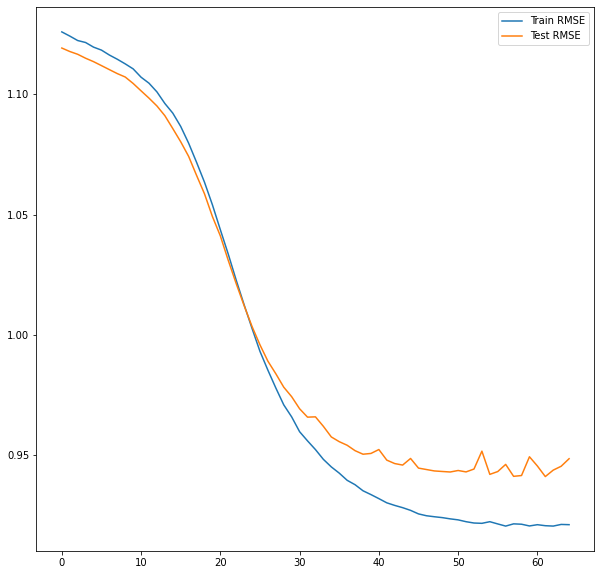

In [13]:
# 학습 과정 시각화
plt.figure(figsize=(10, 10))
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

In [15]:
# 모델로 test 데이터 예측
predictions = model.predict([test_user_ids, test_movie_ids]) + mu

# 예측값들 확인
predictions[:15]

array([[3.8208745],
       [3.0409997],
       [3.2466128],
       [4.150758 ],
       [3.5898993],
       [2.5780704],
       [3.5251932],
       [3.5610077],
       [4.151126 ],
       [3.9147153],
       [3.4090788],
       [3.6488066],
       [3.1904917],
       [3.2667305],
       [2.856459 ]], dtype=float32)

In [16]:
# 실제값
print(ratings_test.rating[:15])

59286    4
71695    3
70788    5
48299    4
16144    5
67827    4
59373    2
32506    4
48843    4
3767     4
10090    3
24858    2
43351    3
49282    3
11074    2
Name: rating, dtype: int64


In [17]:
import numpy as np

# 넘파이를 활용한 RMSE 함수
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [18]:
# ravel : 1차원으로 변환
y_pred = np.ravel(predictions, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

0.9466724162372433